In [ ]:
!pip install fastai
!pip install transformers

In [46]:
import fastai
import transformers
print('fastai version :', fastai.__version__)
print('transformers version :', transformers.__version__)

fastai version : 1.0.61
transformers version : 4.15.0


In [47]:
import numpy as np
import pandas as pd
from pathlib import Path 
import os
import torch
import torch.optim as optim
import random 
# fastai
from fastai import *
from fastai.text import *
from fastai.callbacks import *

from transformers import PreTrainedModel, PreTrainedTokenizer, PretrainedConfig
from transformers import BertForMaskedLM, BertTokenizer, pipeline, BertForSequenceClassification, BertConfig

In [48]:
from google.colab import files
from google.colab import drive
drive._mount('/content/gdrive')#, force_remount=True

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [49]:
torch.cuda.is_available()

True

In [50]:
DATA_ROOT = Path(os.getcwd())/'gdrive'/'MyDrive'/'Thesis Data'/'AA dataset' #Path("./")
BBert = DATA_ROOT/'BanglaBert'
baad6_train = pd.read_csv(DATA_ROOT / 'ulm_train.csv')
baad6_test = pd.read_csv(DATA_ROOT / 'ulm_test.csv')
print(baad6_train.shape,baad6_test.shape)
baad6_train.head()

(1800, 3) (300, 3)


,label,text,is_valid
0,fe,সাম্প্রদায়িক সংঘাত ও মানবিক প্রতিরোধ সাম্প্রদা...,False
1,ij,আজ মাও সেতুং-এর জন্মদিন। মাও সে তুং। বারবার ইত...,False
2,mk,"গোলাম আযমের বিরুদ্ধে অভিযোগ ৬১ টি, যেকোনো ১ টি...",False
3,rn,জলের সন্তরন- (এক) অনেক গুলো সাপ মিজানের শরীরের...,False
4,hm,খুবরগুড়ে . . . এইভাবে হতে থাকে ক্রমাগত কেউ মার...,False


In [51]:
# Parameters
seed = 42
use_fp16 = False
bs = 6
model_name = "sagorsarker/bangla-bert-base"

In [52]:
def seed_all(seed_value):
    random.seed(seed_value) # Python
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu  vars
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
        torch.backends.cudnn.deterministic = True  # needed
        torch.backends.cudnn.benchmark = False

In [53]:
seed_all(seed)

In [54]:
class TransformersBaseTokenizer(BaseTokenizer):
    """Wrapper around PreTrainedTokenizer to be compatible with fast.ai"""
    def __init__(self, pretrained_tokenizer: PreTrainedTokenizer, model_type = 'bert', **kwargs):
        self._pretrained_tokenizer = pretrained_tokenizer
        self.max_seq_len = 512 # pretrained_tokenizer.model_max_length (it's wrongly set in the model config)
        self.model_type = model_type

    def __call__(self, *args, **kwargs): 
        return self

    def tokenizer(self, t:str) -> List[str]:
        """Limits the maximum sequence length and add the special tokens"""
        CLS = self._pretrained_tokenizer.cls_token
        SEP = self._pretrained_tokenizer.sep_token
        if self.model_type in ['roberta']:
            tokens = self._pretrained_tokenizer.tokenize(t, add_prefix_space=True)[:self.max_seq_len - 2]
        else:
            tokens = self._pretrained_tokenizer.tokenize(t)[:self.max_seq_len - 2]
        return [CLS] + tokens + [SEP]

In [55]:
transformer_tokenizer = BertTokenizer.from_pretrained(model_name)
transformer_base_tokenizer = TransformersBaseTokenizer(pretrained_tokenizer = transformer_tokenizer, model_type = 'bert')
fastai_tokenizer = Tokenizer(tok_func = transformer_base_tokenizer, pre_rules=[], post_rules=[])

In [56]:
transformer_tokenizer.cls_token, transformer_tokenizer.sep_token

('[CLS]', '[SEP]')

In [57]:
# tokenizer_class.pretrained_vocab_files_map
transformer_tokenizer

PreTrainedTokenizer(name_or_path='sagorsarker/bangla-bert-base', vocab_size=101975, model_max_len=1000000000000000019884624838656, is_fast=False, padding_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

In [58]:
class TransformersVocab(Vocab):
    def __init__(self, tokenizer: PreTrainedTokenizer):
        super(TransformersVocab, self).__init__(itos = [])
        self.tokenizer = tokenizer
    
    def numericalize(self, t:Collection[str]) -> List[int]:
        "Convert a list of tokens `t` to their ids."
        return self.tokenizer.convert_tokens_to_ids(t)
        #return self.tokenizer.encode(t)

    def textify(self, nums:Collection[int], sep=' ') -> List[str]:
        "Convert a list of `nums` to their tokens."
        nums = np.array(nums).tolist()
        return sep.join(self.tokenizer.convert_ids_to_tokens(nums)) if sep is not None else self.tokenizer.convert_ids_to_tokens(nums)

In [59]:
transformer_vocab =  TransformersVocab(tokenizer = transformer_tokenizer)
numericalize_processor = NumericalizeProcessor(vocab=transformer_vocab)
tokenize_processor = TokenizeProcessor(tokenizer=fastai_tokenizer, include_bos=False, include_eos=False)
transformer_processor = [tokenize_processor, numericalize_processor]

In [60]:
pad_first = bool(model_type in ['xlnet'])
pad_idx = transformer_tokenizer.pad_token_id

In [61]:
databunch = (TextList.from_df(baad6_train, cols='text', processor=transformer_processor)
             .split_by_rand_pct(0.1,seed=seed)
             .label_from_df(cols= 'label')
             .add_test(baad6_test)
             .databunch(bs=bs, pad_first=pad_first, pad_idx=pad_idx))

/usr/local/lib/python3.7/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(a, dtype=dtype, **kwargs)


In [62]:
databunch.show_batch()

text,target
"[CLS] পানশালা [UNK] পানশালা শির ##ে ##ানা ##মের একটা সিরিজ লেখা শর করেছিলাম অনেক আগে । শিবরাম চক ##র ##বর ##তি আমার অনেক মানস ##গর ##দের একজন , তাই পান ##পরে ##মিক কি ##ছ চরিত ##রে ##র মখ ##ে [UNK] গজে দি ##যে গল ##প বলা ##নে ##ার চে ##ষট ##া করেছিলাম ( কি ##ছ ##দিন আগে সচল মদ ##ল আহমেদের "" বক বড ##ে ##া "" করার গল ##পটি",hm
"[CLS] জঙ ##গি দমনে সাফ ##ল ##য ও করন ##ী ##য বাংলাদেশের সমাজের অভ ##যন ##তর ##ে জঙ ##গিব ##াদ যে গভীর শিক ##ড গর ##ে ##াথ ##িত করেছে , তা আজ আর বলার অপ ##েক ##ষা রাখে না । গত দই দশক ধরে আমরা জঙ ##গিব ##াদের বিস ##তত ##ি ও এর ব ##যা ##পক ধবংস ##াত ##মক করম ##কষ ##মতা দেখে এসেছি । মাঝখানে বছর দই - তিনেক",mk
"[CLS] জাগ ##রত পর ##জন ##ম চ ##তব ##র , চলে ##া চলে ##া , শাহবাগ চলে ##া । । রেজা ঘটক শিশ ##র মখ ##ে , শাহবাগ । মা ##যে ##র মখ ##ে , শাহবাগ । বে ##ানের মখ ##ে , শাহবাগ । ভাই ##যে ##র মখ ##ে , শাহবাগ । বাংলার ঘরে ঘরে এখন কেবলই শাহবাগ । শাহবাগের পর ##জন ##ম চ ##তব ##রে এখন একশ শতকের বাংলার",rg
"[CLS] নয ##ন তে ##ামা ##রে পা ##যন ##া দেখি ##তে , র ##যে ##ছ নয ##নে নয ##নে _ _ _ ( পরব - চার ) হ ##মা ##যন আহমেদের নিন ##দক ##েরা বলেন , হ ##মা ##যন আহমেদ হিম চরিত ##র ##টি সবে ##াধ ঘে ##া ##ষের ' শন বরন ##ারী ' উপ ##ন ##যা ##স থেকে নে ##যা হযেছে । খ ##বই হাস ##য ##কর কথা ।",rn
[CLS] কমবে ##াড ##িয ##ার গন ##হত ##যা _ খেমার রজ শাসনের এক বিভীষিকা ##ম ##য অধ ##যা ##য । ছে ##াট ##ট এই মে ##যেটি ##কেও খেমার রজ গেরিলারা রেহাই দে ##যন ##ি । রজ শব ##দ ##টা ফরাসী ; অর ##থ লাল । কাজেই খেমার রজ শব ##দের অর ##থ : লাল খেমার । কমবে ##াড ##িয ##ার [UNK] % লে ##াক ##ই খেমার জন ##গে ##া ##ষ,ij


In [63]:
databunch.train_dl.classes

['fe', 'hm', 'ij', 'mk', 'rg', 'rn']

In [64]:
len(databunch.train_dl.classes)

6

In [65]:
# defining our model architecture 
class CustomTransformerModel(nn.Module):
    def __init__(self, transformer_model: PreTrainedModel):
        super(CustomTransformerModel,self).__init__()
        self.transformer = transformer_model
        
    def forward(self, input_ids, attention_mask=None):
        logits = self.transformer(input_ids,attention_mask = attention_mask)[0]   
        return logits

In [66]:
config = BertConfig.from_pretrained(model_name)
config.num_labels = len(databunch.train_dl.classes)
config.use_bfloat16 = use_fp16
# print(config)

In [67]:
transformer_model = BertForSequenceClassification.from_pretrained(model_name, config = config)
custom_transformer_model = CustomTransformerModel(transformer_model = transformer_model)

Some weights of the model checkpoint at sagorsarker/bangla-bert-base were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

In [68]:
from fastai.callbacks import *
from transformers import AdamW

learner = Learner(databunch, 
                  custom_transformer_model, 
                  opt_func = lambda input: AdamW(input,correct_bias=False), 
                  metrics=[accuracy])

# Show graph of learner stats and metrics after each epoch.
learner.callbacks.append(ShowGraph(learner))

# Put learn in FP16 precision mode. --> Seems to not working
if use_fp16: learner = learner.to_fp16()

In [69]:
# print(learner.model)

We can decide to divide the model in 14 blocks :
* 1 Embedding
* 12 transformer
* 1 classifier

(same for bert)
In this case, we can split our model in this way :

In [70]:
# For bert-base
list_layers = [learner.model.transformer.bert.embeddings,
              learner.model.transformer.bert.encoder.layer[0],
              learner.model.transformer.bert.encoder.layer[1],
              learner.model.transformer.bert.encoder.layer[2],
              learner.model.transformer.bert.encoder.layer[3],
              learner.model.transformer.bert.encoder.layer[4],
              learner.model.transformer.bert.encoder.layer[5],
              learner.model.transformer.bert.encoder.layer[6],
              learner.model.transformer.bert.encoder.layer[7],
              learner.model.transformer.bert.encoder.layer[8],
              learner.model.transformer.bert.encoder.layer[9],
              learner.model.transformer.bert.encoder.layer[10],
              learner.model.transformer.bert.encoder.layer[11],
              learner.model.transformer.bert.pooler]

Check groups : 

In [71]:
learner.split(list_layers)
num_groups = len(learner.layer_groups)
print('Learner split in',num_groups,'groups')
# print(learner.layer_groups)

Learner split in 14 groups


### Train
Now we can finally use all the fastai build-in features to train our model. Like the ULMFiT method, we will use **Slanted Triangular Learning Rates**, **Discriminate Learning Rate** and **gradually unfreeze the model**.

In [ ]:
# !mkdir "{BBert}"

In [ ]:
# learner.save('aa1/untrain')
# seed_all(seed)
# learner.load('aa1/untrain');

In [ ]:
# We check which layer are trainable
learner.summary()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.74E-03
Min loss divided by 10: 2.09E-04


epoch,train_loss,valid_loss,accuracy,time
0,1.857548,1.358259,0.461111,02:06
1,0.954817,0.842977,0.694444,02:06


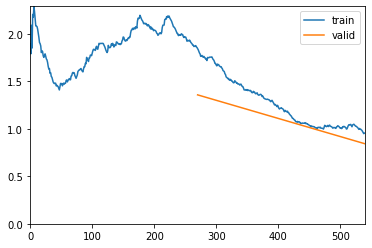

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-07
Min loss divided by 10: 1.10E-07


epoch,train_loss,valid_loss,accuracy,time
0,0.822180,0.829207,0.705556,02:19
1,0.804653,0.808986,0.711111,02:19
2,0.818125,0.805508,0.716667,02:19


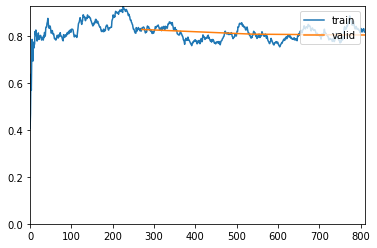

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 1.10E-07


epoch,train_loss,valid_loss,accuracy,time
0,0.821927,0.740140,0.738889,05:27
1,0.655276,0.663467,0.788889,05:27
2,0.621296,0.613043,0.800000,05:27
3,0.511912,0.596392,0.805556,05:26
4,0.568326,0.593779,0.800000,05:26


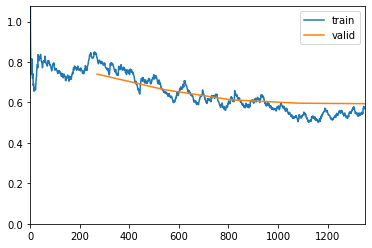

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.10E-06
Min loss divided by 10: 2.75E-07


epoch,train_loss,valid_loss,accuracy,time
0,0.567691,0.580254,0.811111,05:27
1,0.549546,0.547093,0.827778,05:27
2,0.465905,0.506141,0.833333,05:27
3,0.456430,0.495443,0.838889,05:26
4,0.454893,0.491867,0.844444,05:27


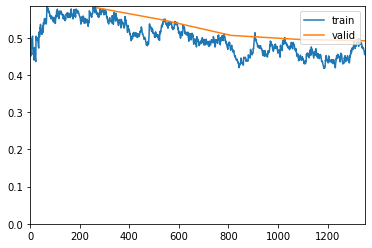

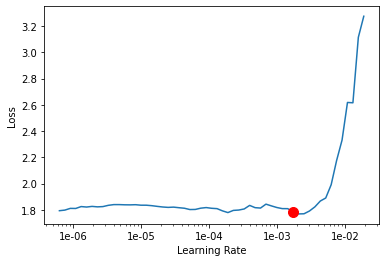

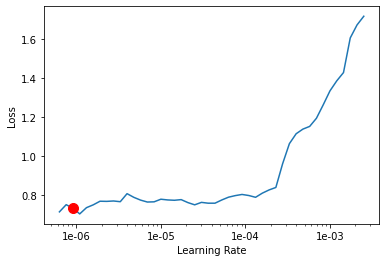

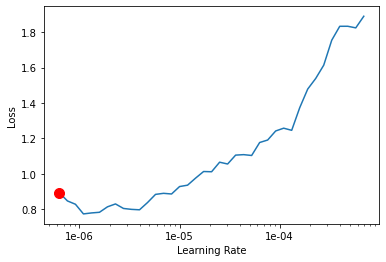

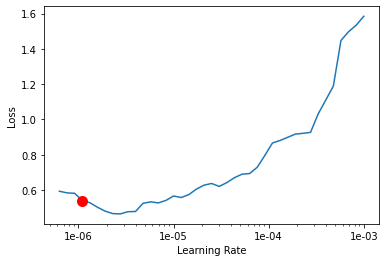

In [39]:
# freeze all the groups but the classifier
learner.freeze_to(-1)
learner.lr_find()
learner.recorder.plot(suggestion=True)
lr = learner.recorder.min_grad_lr
learner.fit_one_cycle(2,max_lr=lr,moms=(0.8,0.7))

learner.freeze_to(-2)
learner.lr_find()
learner.recorder.plot(suggestion=True)
lr = learner.recorder.min_grad_lr
learner.fit_one_cycle(3, max_lr=slice(lr*0.95**num_groups, lr), moms=(0.8, 0.9))

learner.unfreeze()
learner.lr_find()
learner.recorder.plot(suggestion=True)
lr = learner.recorder.min_grad_lr
learner.fit_one_cycle(5, max_lr=slice(lr*0.95**num_groups, lr), moms=(0.8, 0.9))
learner.save(BBert/'baad6_epoch_10')

learner.lr_find()
learner.recorder.plot(suggestion=True)
learner.fit_one_cycle(5, max_lr=slice(lr*0.95**num_groups, lr), moms=(0.8, 0.9))
learner.save(BBert/'baad6_epoch_15')

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-07
Min loss divided by 10: 6.31E-08


epoch,train_loss,valid_loss,accuracy,time
0,0.490785,0.483711,0.855556,05:23
1,0.425147,0.461020,0.850000,05:24
2,0.401236,0.439082,0.838889,05:24
3,0.403828,0.424803,0.872222,05:23
4,0.381688,0.423162,0.872222,05:23


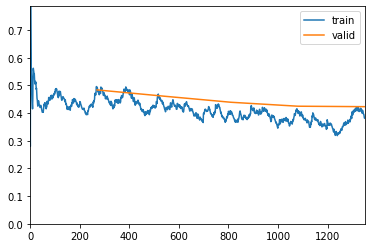

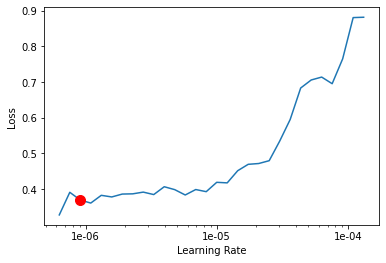

In [43]:
learner.lr_find()
learner.recorder.plot(suggestion=True)
learner.fit_one_cycle(5, max_lr=slice(lr*0.95**num_groups, lr), moms=(0.8, 0.9))
learner.save(BBert/'baad6_epoch_20')

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 2.29E-07


epoch,train_loss,valid_loss,accuracy,time
0,0.362103,0.414494,0.872222,05:23
1,0.337373,0.400337,0.872222,05:23
2,0.303927,0.377858,0.888889,05:22
3,0.298281,0.372386,0.894444,05:22
4,0.265724,0.371332,0.894444,05:22


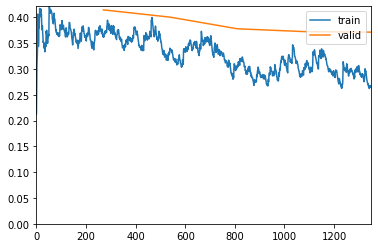

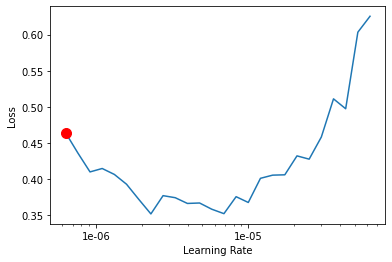

In [44]:
learner.lr_find()
learner.recorder.plot(suggestion=True)
learner.fit_one_cycle(5, max_lr=slice(lr*0.95**num_groups, lr), moms=(0.8, 0.9))
learner.save(BBert/'baad6_epoch_25')

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.91E-06
Min loss divided by 10: 9.12E-08


epoch,train_loss,valid_loss,accuracy,time
0,0.294228,0.362709,0.900000,05:23
1,0.254466,0.355844,0.905556,05:23
2,0.257281,0.345409,0.916667,05:23
3,0.223289,0.342539,0.911111,05:26
4,0.232623,0.340296,0.911111,05:23


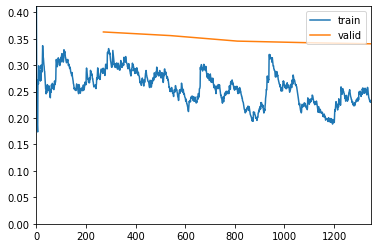

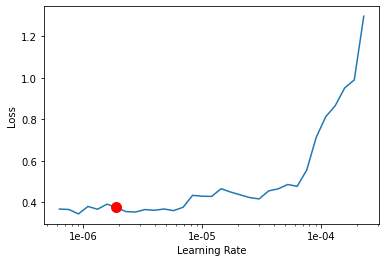

In [72]:
learner.load(BBert/'baad6_epoch_25')
learner.lr_find()
learner.recorder.plot(suggestion=True)
learner.fit_one_cycle(5, max_lr=slice(lr*0.95**num_groups, lr), moms=(0.8, 0.9))
learner.save(BBert/'baad6_epoch_30')

### Creating prediction
Now that the model is trained, we want to generate predictions from the test dataset.

In [73]:
def testing(df, model):
    text_array = df["text"].tolist()
    print(len(text_array))

    final_preds = []

    for text in text_array:
      preds = model.predict(text)
      final_preds.append(str(preds[0]))

    targets = df["label"].tolist()

    err=[]
    count =0;
    tst = len(text_array)

    for i in range(tst):
        if(targets[i]==final_preds[i]):
          count = count+1
        else:
          err.append((targets[i],final_preds[i]))
    print("Accuracy: ")
    print(count/tst)
    print(err)

    return final_preds,targets

In [74]:
len(baad6_test)

300

In [75]:
# baad6_epoch_15
pred,targ = testing(baad6_test,learner) ## from 2,3,10

300
Accuracy: 
0.9033333333333333
[('ij', 'rn'), ('rn', 'mk'), ('rn', 'mk'), ('rn', 'ij'), ('hm', 'rn'), ('rn', 'ij'), ('mk', 'fe'), ('ij', 'rn'), ('rg', 'mk'), ('rn', 'mk'), ('mk', 'rg'), ('rn', 'mk'), ('rg', 'fe'), ('rg', 'fe'), ('rn', 'ij'), ('hm', 'rn'), ('rn', 'ij'), ('mk', 'rn'), ('rn', 'rg'), ('rn', 'ij'), ('hm', 'rn'), ('rg', 'rn'), ('fe', 'mk'), ('rn', 'mk'), ('mk', 'rg'), ('rg', 'mk'), ('rn', 'mk'), ('rn', 'mk'), ('rn', 'mk')]
